# Наилучшее соответствие $H_{\alpha}$ & $Q_{eff}$

In [2]:
import os
import numpy as np

%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
Qeff_min = np.load('./data/Qeff_min.npy')
Qeff_max = np.load('./data/Qeff_max.npy')
Qg = np.load('./data/Qg.npy')
H_alpha = np.load('./data/H_alpha.npy')
dist_kpc = np.load('./data/dist_kpc.npy')
sigma_s = np.load('./data/sigma_s.npy')

Text(0.5, 1.0, '$Q_{eff}^{max}$')

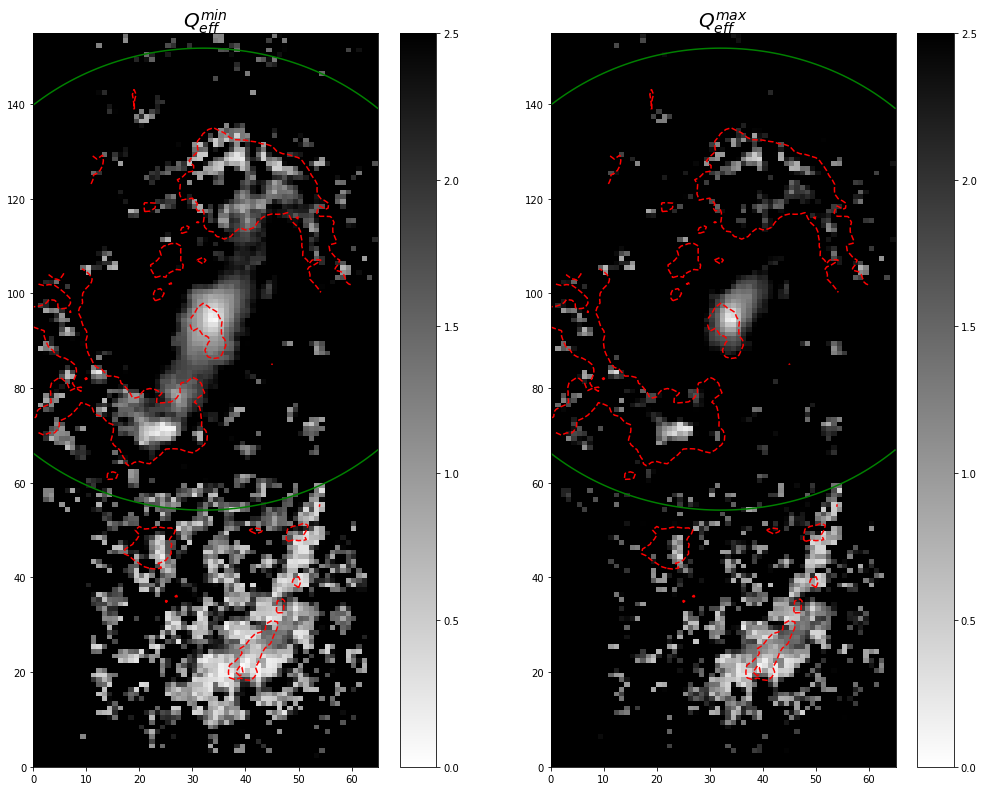

In [28]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, dist_kpc, levels=[0,5], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=2.5)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, dist_kpc, levels=[0,5], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=2.5)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)


вне 5 кпк всё не очень хорошо, попробуем при нашем статистическом исследовании отбросить всё, что находится вне этого круга и посмотрим, что из этого выйдет

## $\chi^2$

In [10]:
def chisqg(ydata,ymod,sd=None):   
    if sd==None:  
        chisq=numpy.sum((ydata-ymod)**2)  
    else:  
        chisq=numpy.sum( ((ydata-ymod)/sd)**2 )  
    return chisq  


Text(0.5, 1.0, '$Q_{max}$')

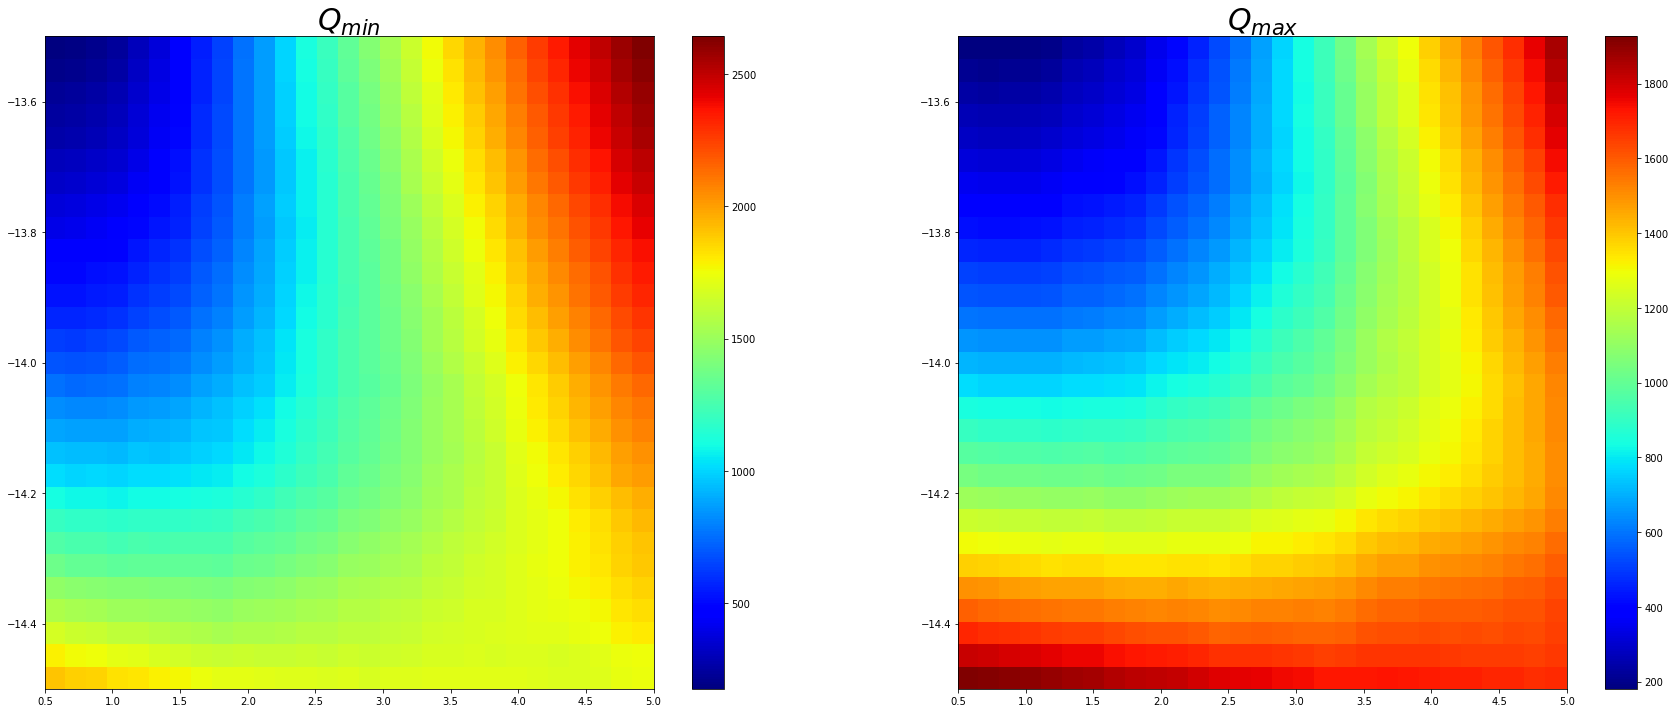

In [25]:
fig = plt.figure(figsize=[30, 12])

plt.subplot(1,2,1)
corr_coeffs = np.zeros((30,30))
for i, qlim in enumerate(np.linspace(0.5, 5., 30)):
    for j, hlim in enumerate(np.linspace(-14.5, -13.5, 30)):
        mask = (sigma_s != 0.) & (dist_kpc < 5.)
        corr_coeffs[j][i] = chisqg(np.array([1 if l < qlim else 0 for l in Qeff_min[mask].ravel()]), 
                                   np.array([1 if l > hlim else 0 for l in np.log10(H_alpha)[mask].ravel()]))
        
xx, yy = np.meshgrid(np.linspace(0.5, 5., 30), np.linspace(-14.5, -13.5, 30))
quadmesh = plt.pcolormesh(xx, yy, corr_coeffs, cmap='jet')
# quadmesh.set_clim(vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title(r'$Q_{min}$', fontsize=30)

plt.subplot(1,2,2)
corr_coeffs = np.zeros((30,30))
for i, qlim in enumerate(np.linspace(0.5, 5., 30)):
    for j, hlim in enumerate(np.linspace(-14.5, -13.5, 30)):
        mask = (sigma_s != 0.) & (dist_kpc < 5.)
        corr_coeffs[j][i] = chisqg(np.array([1 if l < qlim else 0 for l in Qeff_max[mask].ravel()]), 
                                   np.array([1 if l > hlim else 0 for l in np.log10(H_alpha)[mask].ravel()]))
        
xx, yy = np.meshgrid(np.linspace(0.5, 5., 30), np.linspace(-14.5, -13.5, 30))
quadmesh = plt.pcolormesh(xx, yy, corr_coeffs, cmap='jet')
# quadmesh.set_clim(vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title(r'$Q_{max}$', fontsize=30)



Попробуем найти precision, recall и F1 из http://bazhenov.me/blog/2012/07/21/classification-performance-evaluation.html

$$precision = \frac{TP}{TP+FP}$$ 

$$recall = \frac{TP}{TP+FN}$$ 

$$F1 = 2 \frac{precision \cdot recall}{precision + recall}$$

In [6]:
precision_Qmin=np.zeros((50,50))
recall_Qmin = np.zeros((50,50))
F1_Qmin = np.zeros((50,50))

for i, qlim in enumerate(np.linspace(0.5, 5., 50)):
    for j, hlim in enumerate(np.linspace(-14.5, -13.5, 50)):
        TP = 0
        FP = 0
        FN = 0
        for k, row in enumerate(dist_kpc):
            for l, col in enumerate(dist_kpc[0]):
                
                if (Qeff_min[k][l] <= qlim) & (np.log10(H_alpha[k][l]) >= hlim):
                    TP+=1
                    
                if (Qeff_min[k][l] >= qlim) & (np.log10(H_alpha[k][l]) >= hlim):  
                    FP+=1
                
                if (Qeff_min[k][l] <= qlim) & (np.log10(H_alpha[k][l]) <= hlim):
                    FN+=1
         
        precision_Qmin[i][j] = TP/(TP + FP)
        recall_Qmin[i][j] = TP/(TP + FN)
        F1_Qmin[i][j] = 2*precision_Qmin[i][j] * recall_Qmin[i][j]/(precision_Qmin[i][j] + recall_Qmin[i][j])
                    

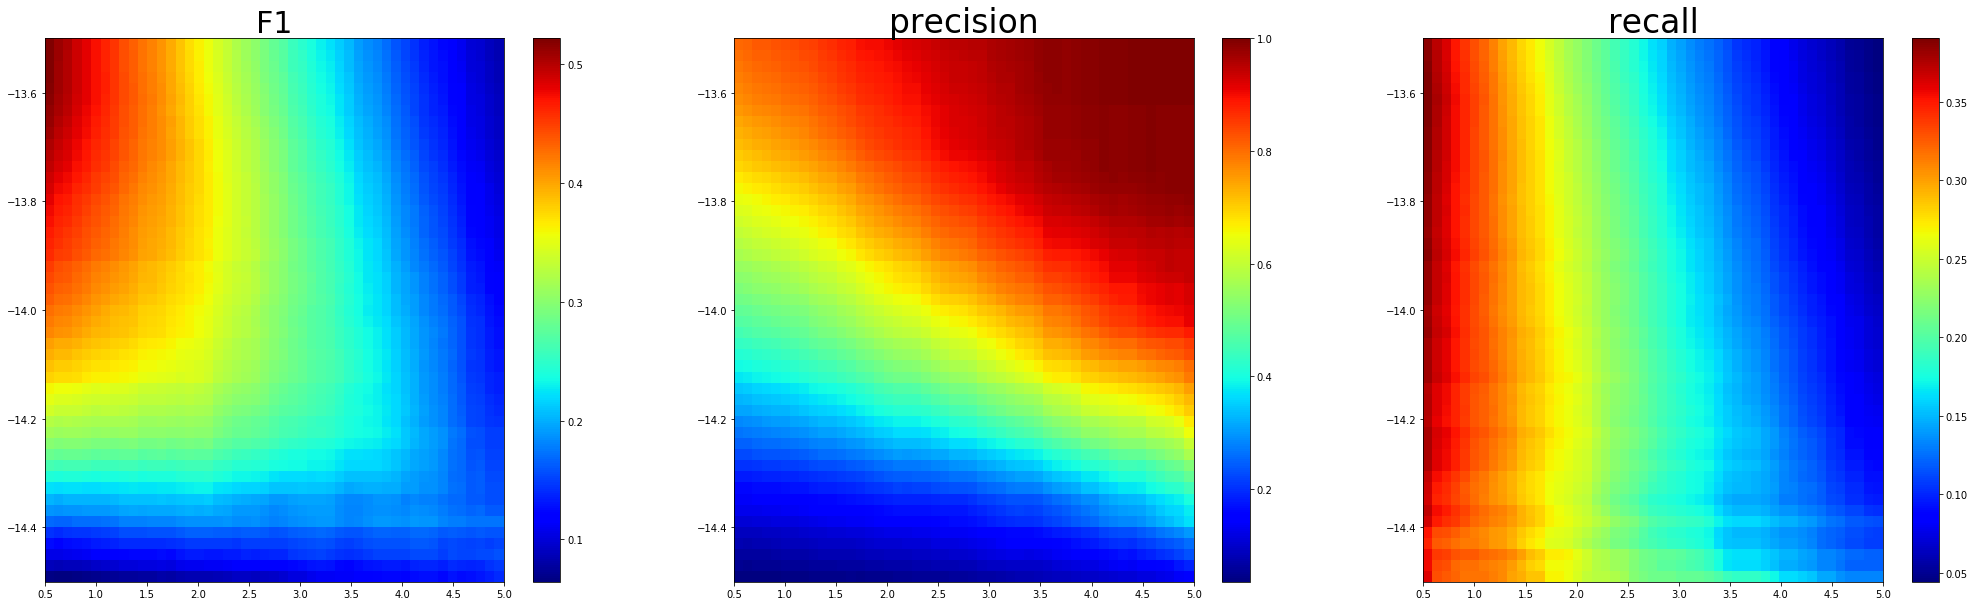

In [12]:
xx, yy = np.meshgrid(np.linspace(0.5, 5., 50), np.linspace(-14.5, -13.5, 50))
fig = plt.figure(figsize=[35, 10])

plt.subplot(1,3,1)
quadmesh = plt.pcolormesh(xx, yy, F1_Qmin, cmap='jet')
plt.title('F1', fontsize=30)
plt.colorbar()
          
plt.subplot(1,3,2)
quadmesh = plt.pcolormesh(xx, yy, precision_Qmin, cmap='jet')
plt.title('precision', fontsize=33)
plt.colorbar()
          
plt.subplot(1,3,3)
quadmesh = plt.pcolormesh(xx, yy, recall_Qmin, cmap='jet')
plt.title('recall', fontsize=33)
plt.colorbar()       
          

In [7]:
precision_Qmax=np.zeros((50,50))
recall_Qmax = np.zeros((50,50))
F1_Qmax = np.zeros((50,50))

for i, qlim in enumerate(np.linspace(0.5, 5., 50)):
    for j, hlim in enumerate(np.linspace(-14.5, -13.5, 50)):
        TP = 0
        FP = 0
        FN = 0
        for k, row in enumerate(dist_kpc):
            for l, col in enumerate(dist_kpc[0]):
                
                if (Qeff_max[k][l] <= qlim) & (np.log10(H_alpha[k][l]) >= hlim):
                    TP+=1
                    
                if (Qeff_max[k][l] >= qlim) & (np.log10(H_alpha[k][l]) >= hlim):  
                    FP+=1
                
                if (Qeff_max[k][l] <= qlim) & (np.log10(H_alpha[k][l]) <= hlim):
                    FN+=1
         
        precision_Qmax[i][j] = TP/(TP + FP)
        recall_Qmax[i][j] = TP/(TP + FN)
        F1_Qmax[i][j] = 2*precision_Qmax[i][j] * recall_Qmax[i][j]/(precision_Qmax[i][j] + recall_Qmax[i][j])
                    
            
            

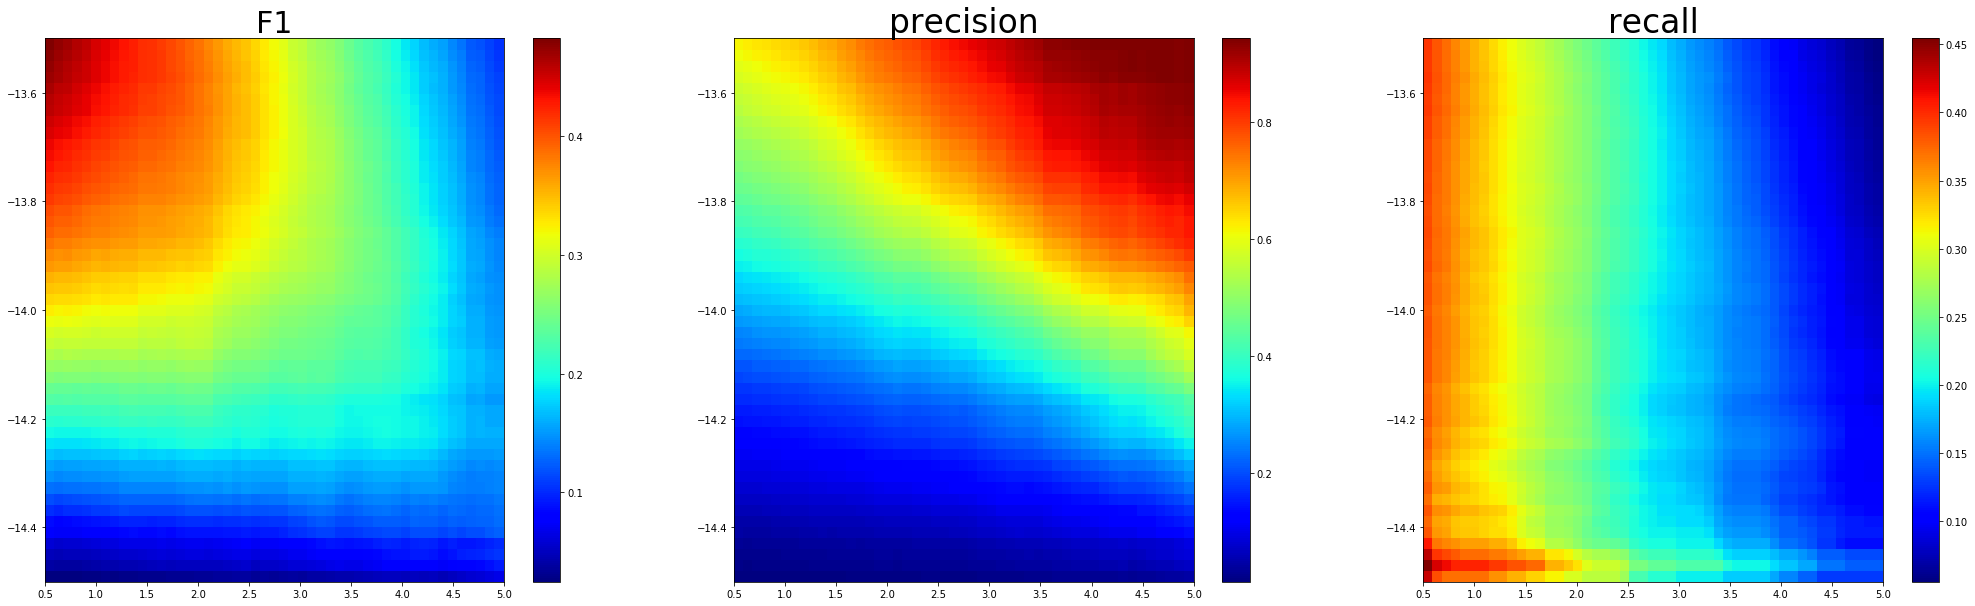

In [13]:
xx, yy = np.meshgrid(np.linspace(0.5, 5., 50), np.linspace(-14.5, -13.5, 50))
fig = plt.figure(figsize=[35, 10])

plt.subplot(1,3,1)
quadmesh = plt.pcolormesh(xx, yy, F1_Qmax, cmap='jet')
plt.title('F1', fontsize=30)
plt.colorbar()
          
plt.subplot(1,3,2)
quadmesh = plt.pcolormesh(xx, yy, precision_Qmax, cmap='jet')
plt.title('precision', fontsize=33)
plt.colorbar()
          
plt.subplot(1,3,3)
quadmesh = plt.pcolormesh(xx, yy, recall_Qmax, cmap='jet')
plt.title('recall', fontsize=33)
plt.colorbar() 

In [15]:
precision_Qg=np.zeros((50,50))
recall_Qg = np.zeros((50,50))
F1_Qg = np.zeros((50,50))

for i, qlim in enumerate(np.linspace(0.5, 5., 50)):
    for j, hlim in enumerate(np.linspace(-14.5, -13.5, 50)):
        TP = 0
        FP = 0
        FN = 0
        for k, row in enumerate(dist_kpc):
            for l, col in enumerate(dist_kpc[0]):
                
                if (Qg[k][l] <= qlim) & (np.log10(H_alpha[k][l]) >= hlim):
                    TP+=1
                    
                if (Qg[k][l] >= qlim) & (np.log10(H_alpha[k][l]) >= hlim):  
                    FP+=1
                
                if (Qg[k][l] <= qlim) & (np.log10(H_alpha[k][l]) <= hlim):
                    FN+=1
         
        precision_Qg[i][j] = TP/(TP + FP)
        recall_Qg[i][j] = TP/(TP + FN)
        F1_Qg[i][j] = 2*precision_Qg[i][j] * recall_Qg[i][j]/(precision_Qg[i][j] + recall_Qg[i][j])
                    

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


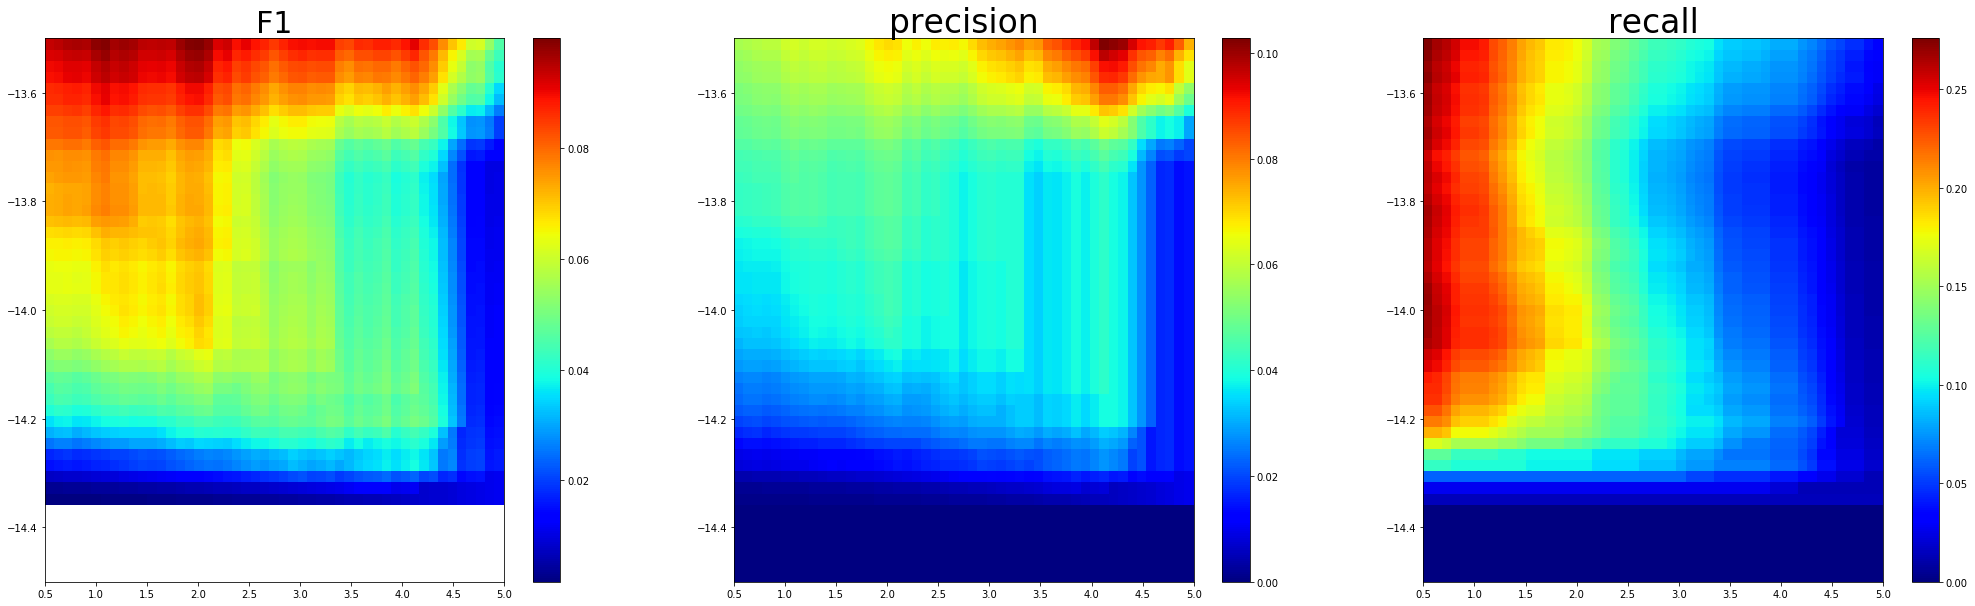

In [16]:
xx, yy = np.meshgrid(np.linspace(0.5, 5., 50), np.linspace(-14.5, -13.5, 50))
fig = plt.figure(figsize=[35, 10])

plt.subplot(1,3,1)
quadmesh = plt.pcolormesh(xx, yy, F1_Qg, cmap='jet')
plt.title('F1', fontsize=30)
plt.colorbar()
          
plt.subplot(1,3,2)
quadmesh = plt.pcolormesh(xx, yy, precision_Qg, cmap='jet')
plt.title('precision', fontsize=33)
plt.colorbar()
          
plt.subplot(1,3,3)
quadmesh = plt.pcolormesh(xx, yy, recall_Qg, cmap='jet')
plt.title('recall', fontsize=33)
plt.colorbar()

In [17]:
np.save('./data/precision_Qg.npy',precision_Qg)
np.save('./data/recall_Qg.npy',recall_Qg)
np.save('./data/F1_Qg.npy',F1_Qg)
np.save('./data/precision_Qmin.npy',precision_Qmin)
np.save('./data/recall_Qmin.npy',recall_Qmin)
np.save('./data/F1_Qmin.npy',F1_Qmin)
np.save('./data/precision_Qmax.npy',precision_Qmax)
np.save('./data/recall_Qmax.npy',recall_Qmax)
np.save('./data/F1_Qmax.npy',F1_Qmax)

Теперь попробуем откинуть всё, что находится дальше, чем 5 кпк от центра галактики.

In [24]:
precision_Qmin_=np.zeros((50,50))
recall_Qmin_ = np.zeros((50,50))
F1_Qmin_ = np.zeros((50,50))

for i, qlim in enumerate(np.linspace(0.5, 5., 50)):
    for j, hlim in enumerate(np.linspace(-14.5, -13.5, 50)):
        TP = 0
        FP = 0
        FN = 0
        for k, row in enumerate(dist_kpc):
            for l, col in enumerate(dist_kpc[0]):
                if (dist_kpc[k][l] <= 5): 
                    if (Qeff_min[k][l] <= qlim) & (np.log10(H_alpha[k][l]) >= hlim):
                        TP+=1
                    
                    if (Qeff_min[k][l] >= qlim) & (np.log10(H_alpha[k][l]) >= hlim):  
                        FP+=1
                
                    if (Qeff_min[k][l] <= qlim) & (np.log10(H_alpha[k][l]) <= hlim):
                        FN+=1
         
        precision_Qmin_[i][j] = TP/(TP + FP)
        recall_Qmin_[i][j] = TP/(TP + FN)
        F1_Qmin_[i][j] = 2*precision_Qmin_[i][j] * recall_Qmin_[i][j]/(precision_Qmin_[i][j] + recall_Qmin_[i][j])

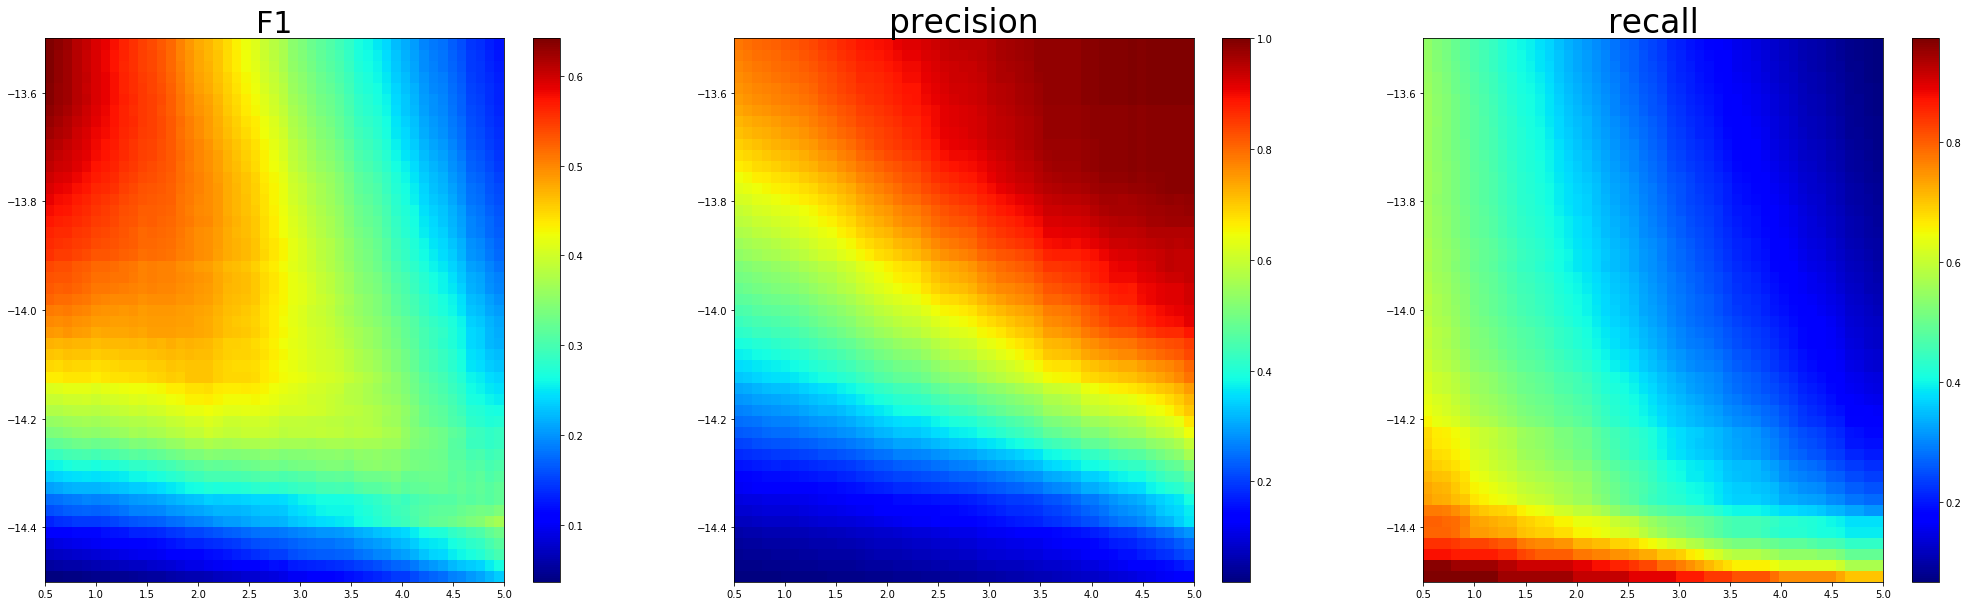

In [25]:
xx, yy = np.meshgrid(np.linspace(0.5, 5., 50), np.linspace(-14.5, -13.5, 50))
fig = plt.figure(figsize=[35, 10])

plt.subplot(1,3,1)
quadmesh = plt.pcolormesh(xx, yy, F1_Qmin_, cmap='jet')
plt.title('F1', fontsize=30)
plt.colorbar()
          
plt.subplot(1,3,2)
quadmesh = plt.pcolormesh(xx, yy, precision_Qmin_, cmap='jet')
plt.title('precision', fontsize=33)
plt.colorbar()
          
plt.subplot(1,3,3)
quadmesh = plt.pcolormesh(xx, yy, recall_Qmin_, cmap='jet')
plt.title('recall', fontsize=33)
plt.colorbar()  